# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
os.environ["CUDA_LAUNCH_BLOCKING"]="1, 2, 3, 4"

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

# Import Data

In [3]:
items = pd.read_csv("../Datasets/ml-100k/Text/items.csv")

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../Datasets/ml-100k/Text/u.data', sep='\t', names=r_cols,encoding='latin-1')

In [4]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

In [5]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [6]:
data_matrix_emp = data_matrix.copy()
data_matrix_emp[data_matrix < 4] = 0
data_matrix_emp[data_matrix >= 4]= 1 

In [7]:
indices = list(zip(*(np.where(data_matrix != 0))))

In [8]:
np.unique(data_matrix, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]),
 array([1486126,    6110,   11370,   27145,   34174,   21201]))

In [9]:
items_csv = "../Datasets/ml-100k/Text/items.csv"
train_ratings = "../Datasets/ml-100k/Text/u1.base"
test_ratings = "../Datasets/ml-100k/Text/u1.test"
embeddings = "../Datasets/ml-100k/Video/embeddings.csv"

In [10]:
embeddings_ = pd.read_csv(embeddings).to_numpy()

In [11]:
embeddings_.shape

(1682, 2048)

# Encoder network

## Data loader

In [12]:
import torch
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

In [13]:
torch.cuda.is_available()

True

In [14]:
torch.__version__

'1.10.1'

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class MovielensDataset(Dataset):
    def __init__(self, items_csv = items_csv, ratings = train_ratings, 
                 embeddings = embeddings, indices = indices, device = device):
        self.items = pd.read_csv(items_csv).to_numpy()
        self.item_embeddings = pd.read_csv(embeddings).to_numpy()
        self.ratings = pd.read_csv(ratings, sep='\t', 
                                   names=['user_id', 'movie_id', 'rating', 'unix_timestamp'],encoding='latin-1')
        self.indices = indices
        self.device = device
        self.data = None
        self.data_emp = None
        self.n_users = None
        self.n_items = None
        self.fill_ratings()
        self.embeddings()
    
    def fill_ratings(self, threshold=4):
        self.n_users = self.ratings.user_id.unique().shape[0]
        self.n_items = self.ratings.movie_id.unique().shape[0]
        
        self.data = np.zeros((943, 1682))
        for line in self.ratings.itertuples():
            self.data[line[1]-1, line[2]-1] = line[3]
        
    def embeddings(self):
        self.item_embeddings = np.nan_to_num(self.item_embeddings)
        self.item_embeddings = normalize(self.item_embeddings, axis=1, norm='l2')
        self.user_embeddings = self.data
#         self.user_embeddings = normalize(self.user_embeddings, axis=1, norm='l1')
        self.item_embedding_size = self.item_embeddings.shape[1]
        self.user_embedding_size = self.data.shape[1]
        
    def __len__(self):
        return(len(self.indices))
    
    def __getitem__(self, idx):
        user = self.indices[idx][0]
        item = self.indices[idx][1]

        x1 = torch.from_numpy(self.user_embeddings[user]).to(self.device)
        x2 = torch.from_numpy(self.item_embeddings[item]).to(self.device)
        
        y = self.data[user][item]
        return(x1.float(), x2.float(), int(y))

In [17]:
train_dataset = MovielensDataset(ratings = train_ratings)
test_dataset = MovielensDataset(ratings = test_ratings)

In [18]:
trainloader = DataLoader(train_dataset, batch_size = 30000, shuffle = True)
validloader = DataLoader(test_dataset, batch_size = 10000, shuffle = False)

## Architecture

In [19]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import OrderedDict

In [20]:
from ml_metrics import mapk
from recmetrics import mark

In [21]:
class SiameseNet(nn.Module):
    def __init__(self, device = device):
        super(SiameseNet, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 512)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(512, 300)),
            ('relu2', nn.Sigmoid()),
            ('linr3', nn.Linear(300, 256)),
            ('relu3', nn.LeakyReLU()),
            ('linr4', nn.Linear(256, 500)),
            ('relu4', nn.LeakyReLU()),
#             ('linr5', nn.Linear(300, dataset.item_embedding_size)),
#             ('relu5', nn.LeakyReLU()),
        ]))
        self.decoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(500, 256)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.Sigmoid()),
            ('linr3', nn.Linear(300, 512)),
            ('relu3', nn.LeakyReLU()),
            ('linr4', nn.Linear(512, train_dataset.user_embedding_size)),
#             ('relu4', nn.LeakyReLU()),
        ]))
        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 1024)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(1024, 512)),
            ('relu2', nn.Sigmoid()),
            ('linr3', nn.Linear(512, 500)),
#             ('btch3', nn.BatchNorm1d(200)),
#             ('relu3', nn.LeakyReLU()),
        ]))
        self.decoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(500, 512)),
            ('btch1', nn.BatchNorm1d(512)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(512, 1024)),
            ('relu2', nn.Sigmoid()),
            ('linr3', nn.Linear(1024, train_dataset.item_embedding_size)),
# #             ('drop3', nn.Dropout(p=0.1)),
            ('btch3', nn.BatchNorm1d(train_dataset.item_embedding_size)),
            ('relu3', nn.Sigmoid()),
        ]))
        
        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.decoder_user.apply(self.init_weights)
        self.decoder_item.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x1, x2):
        emb1 = self.encoder_user(x1)
        emb2 = self.encoder_item(x2)
        out1 = self.decoder_user(emb1)
        out2 = self.decoder_item(emb2)
        
        return(emb1, emb2, out1, out2)
    
    def fit(self, trainloader = trainloader, 
            validloader = validloader, epochs = 100):
        self.criterion_recon = nn.MSELoss()
        self.criterion_embed = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 0.005, weight_decay = 1e-4)
        
        train_loss = []
        test_loss = []
        for epoch in range(epochs):
            running_loss = 0.0
            early_stop = 0
            
            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.LongTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                emb1, emb2, out1, out2 = self.forward(x1, x2)
                loss_1 = self.criterion_recon(x1, out1)
                loss_2 = self.criterion_recon(x2, out2)
                loss_3 = self.criterion_embed(emb1, emb2, y_lng * 2 - 1)
                loss = loss_1 + loss_3 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss += loss
            val_loss = self.evaluate()
            
            print('Epoch-%d: Train Loss = %.3f Test Loss = %.3f'%
                  (epoch + 1, running_loss / i, val_loss))
            train_loss.append((running_loss / i).cpu().detach().numpy())
            test_loss.append(val_loss.cpu().detach().numpy())
        return(train_loss, test_loss)
            
    def evaluate(self, k = 3):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(validloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            emb1, emb2, out1, out2 = self.forward(x1, x2)
            loss_1 = self.criterion_recon(x1, out1)
            loss_2 = self.criterion_recon(x2, out2)
            loss_3 = self.criterion_embed(emb1, emb2, y_lng * 2 - 1)
            print(loss_1, loss_2, loss_3)
            loss = (loss_1 + loss_3 + loss_2) 
        return(loss)
    
    def predict(self, data):
        return(self.encoder_user(torch.Tensor(data).to(device)).cpu().detach().numpy())

In [22]:
sm_net = SiameseNet()
sm_net.to(device)

SiameseNet(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1682, out_features=512, bias=True)
    (relu1): Sigmoid()
    (linr2): Linear(in_features=512, out_features=300, bias=True)
    (relu2): Sigmoid()
    (linr3): Linear(in_features=300, out_features=256, bias=True)
    (relu3): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=256, out_features=500, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
  )
  (decoder_user): Sequential(
    (linr1): Linear(in_features=500, out_features=256, bias=True)
    (relu1): Sigmoid()
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): Sigmoid()
    (linr3): Linear(in_features=300, out_features=512, bias=True)
    (relu3): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=512, out_features=1682, bias=True)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=2048, out_features=1024, bias=True)
    (relu1): Sigmoid()
    (linr2): Linear(in_features=1024, out_fea

In [23]:
train_loss, test_loss = sm_net.fit()

4it [00:11,  2.95s/it]


tensor(0.7308, device='cuda:0') tensor(0.1797, device='cuda:0') tensor(0.3718, device='cuda:0')
Epoch-1: Train Loss = 2.574 Test Loss = 1.282


4it [00:11,  2.75s/it]


tensor(0.7442, device='cuda:0') tensor(0.3235, device='cuda:0') tensor(0.3534, device='cuda:0')
Epoch-2: Train Loss = 2.257 Test Loss = 1.421


4it [00:10,  2.73s/it]


tensor(0.7404, device='cuda:0') tensor(0.6189, device='cuda:0') tensor(0.2904, device='cuda:0')
Epoch-3: Train Loss = 2.192 Test Loss = 1.650


4it [00:10,  2.69s/it]


tensor(0.7128, device='cuda:0') tensor(0.6974, device='cuda:0') tensor(0.2691, device='cuda:0')
Epoch-4: Train Loss = 2.161 Test Loss = 1.679


4it [00:10,  2.72s/it]


tensor(0.7110, device='cuda:0') tensor(0.6847, device='cuda:0') tensor(0.2994, device='cuda:0')
Epoch-5: Train Loss = 2.143 Test Loss = 1.695


4it [00:10,  2.70s/it]


tensor(0.7143, device='cuda:0') tensor(0.5621, device='cuda:0') tensor(0.2979, device='cuda:0')
Epoch-6: Train Loss = 2.141 Test Loss = 1.574


4it [00:10,  2.71s/it]


tensor(0.7150, device='cuda:0') tensor(0.5370, device='cuda:0') tensor(0.2732, device='cuda:0')
Epoch-7: Train Loss = 2.132 Test Loss = 1.525


4it [00:10,  2.69s/it]


tensor(0.7165, device='cuda:0') tensor(0.4771, device='cuda:0') tensor(0.2737, device='cuda:0')
Epoch-8: Train Loss = 2.120 Test Loss = 1.467


4it [00:10,  2.70s/it]


tensor(0.7181, device='cuda:0') tensor(0.4131, device='cuda:0') tensor(0.2708, device='cuda:0')
Epoch-9: Train Loss = 2.118 Test Loss = 1.402


4it [00:10,  2.72s/it]


tensor(0.7199, device='cuda:0') tensor(0.4187, device='cuda:0') tensor(0.2672, device='cuda:0')
Epoch-10: Train Loss = 2.112 Test Loss = 1.406


4it [00:10,  2.70s/it]


tensor(0.7153, device='cuda:0') tensor(0.4169, device='cuda:0') tensor(0.2691, device='cuda:0')
Epoch-11: Train Loss = 2.106 Test Loss = 1.401


4it [00:10,  2.69s/it]


tensor(0.7186, device='cuda:0') tensor(0.3896, device='cuda:0') tensor(0.2678, device='cuda:0')
Epoch-12: Train Loss = 2.102 Test Loss = 1.376


4it [00:10,  2.71s/it]


tensor(0.7354, device='cuda:0') tensor(0.3420, device='cuda:0') tensor(0.2748, device='cuda:0')
Epoch-13: Train Loss = 2.102 Test Loss = 1.352


4it [00:10,  2.71s/it]


tensor(0.7187, device='cuda:0') tensor(0.3402, device='cuda:0') tensor(0.2709, device='cuda:0')
Epoch-14: Train Loss = 2.098 Test Loss = 1.330


4it [00:10,  2.72s/it]


tensor(0.7357, device='cuda:0') tensor(0.3354, device='cuda:0') tensor(0.2692, device='cuda:0')
Epoch-15: Train Loss = 2.086 Test Loss = 1.340


4it [00:10,  2.70s/it]


tensor(0.6814, device='cuda:0') tensor(0.4200, device='cuda:0') tensor(0.2724, device='cuda:0')
Epoch-16: Train Loss = 2.069 Test Loss = 1.374


4it [00:10,  2.69s/it]


tensor(0.7805, device='cuda:0') tensor(0.6165, device='cuda:0') tensor(0.2879, device='cuda:0')
Epoch-17: Train Loss = 2.046 Test Loss = 1.685


4it [00:10,  2.69s/it]


tensor(0.7188, device='cuda:0') tensor(0.6311, device='cuda:0') tensor(0.2734, device='cuda:0')
Epoch-18: Train Loss = 2.013 Test Loss = 1.623


4it [00:10,  2.70s/it]


tensor(0.7165, device='cuda:0') tensor(0.8967, device='cuda:0') tensor(0.2943, device='cuda:0')
Epoch-19: Train Loss = 2.008 Test Loss = 1.907


4it [00:10,  2.72s/it]


tensor(0.6707, device='cuda:0') tensor(0.8023, device='cuda:0') tensor(0.2834, device='cuda:0')
Epoch-20: Train Loss = 1.993 Test Loss = 1.756


4it [00:10,  2.70s/it]


tensor(0.6607, device='cuda:0') tensor(0.0417, device='cuda:0') tensor(0.2785, device='cuda:0')
Epoch-21: Train Loss = 1.980 Test Loss = 0.981


4it [00:10,  2.70s/it]


tensor(0.6644, device='cuda:0') tensor(0.0317, device='cuda:0') tensor(0.2831, device='cuda:0')
Epoch-22: Train Loss = 1.977 Test Loss = 0.979


4it [00:10,  2.69s/it]


tensor(0.6702, device='cuda:0') tensor(0.0043, device='cuda:0') tensor(0.2712, device='cuda:0')
Epoch-23: Train Loss = 1.953 Test Loss = 0.946


4it [00:10,  2.69s/it]


tensor(0.6812, device='cuda:0') tensor(0.0206, device='cuda:0') tensor(0.2724, device='cuda:0')
Epoch-24: Train Loss = 1.925 Test Loss = 0.974


4it [00:10,  2.72s/it]


tensor(0.6572, device='cuda:0') tensor(0.2087, device='cuda:0') tensor(0.2745, device='cuda:0')
Epoch-25: Train Loss = 1.911 Test Loss = 1.140


4it [00:10,  2.70s/it]


tensor(0.6606, device='cuda:0') tensor(0.5679, device='cuda:0') tensor(0.2817, device='cuda:0')
Epoch-26: Train Loss = 1.903 Test Loss = 1.510


4it [00:10,  2.70s/it]


tensor(0.6840, device='cuda:0') tensor(0.8013, device='cuda:0') tensor(0.2811, device='cuda:0')
Epoch-27: Train Loss = 1.897 Test Loss = 1.766


4it [00:10,  2.70s/it]


tensor(0.6965, device='cuda:0') tensor(0.8699, device='cuda:0') tensor(0.2932, device='cuda:0')
Epoch-28: Train Loss = 1.880 Test Loss = 1.860


4it [00:10,  2.70s/it]


tensor(0.6738, device='cuda:0') tensor(0.8553, device='cuda:0') tensor(0.3220, device='cuda:0')
Epoch-29: Train Loss = 1.873 Test Loss = 1.851


4it [00:10,  2.73s/it]


tensor(0.6759, device='cuda:0') tensor(0.7438, device='cuda:0') tensor(0.2841, device='cuda:0')
Epoch-30: Train Loss = 1.859 Test Loss = 1.704


4it [00:10,  2.72s/it]


tensor(0.7764, device='cuda:0') tensor(0.5433, device='cuda:0') tensor(0.3646, device='cuda:0')
Epoch-31: Train Loss = 1.838 Test Loss = 1.684


4it [00:10,  2.69s/it]


tensor(0.7321, device='cuda:0') tensor(0.4162, device='cuda:0') tensor(0.4036, device='cuda:0')
Epoch-32: Train Loss = 1.878 Test Loss = 1.552


4it [00:11,  2.76s/it]


tensor(0.7717, device='cuda:0') tensor(0.4177, device='cuda:0') tensor(0.4113, device='cuda:0')
Epoch-33: Train Loss = 1.843 Test Loss = 1.601


4it [00:10,  2.61s/it]


tensor(0.7197, device='cuda:0') tensor(0.4541, device='cuda:0') tensor(0.3613, device='cuda:0')
Epoch-34: Train Loss = 1.835 Test Loss = 1.535


4it [00:10,  2.71s/it]


tensor(0.6902, device='cuda:0') tensor(0.9664, device='cuda:0') tensor(0.3112, device='cuda:0')
Epoch-35: Train Loss = 1.825 Test Loss = 1.968


4it [00:10,  2.69s/it]


tensor(0.6922, device='cuda:0') tensor(0.9709, device='cuda:0') tensor(0.2971, device='cuda:0')
Epoch-36: Train Loss = 1.815 Test Loss = 1.960


4it [00:10,  2.71s/it]


tensor(0.6906, device='cuda:0') tensor(0.9714, device='cuda:0') tensor(0.3076, device='cuda:0')
Epoch-37: Train Loss = 1.808 Test Loss = 1.970


4it [00:10,  2.73s/it]


tensor(0.6802, device='cuda:0') tensor(0.9722, device='cuda:0') tensor(0.2929, device='cuda:0')
Epoch-38: Train Loss = 1.801 Test Loss = 1.945


4it [00:10,  2.73s/it]


tensor(0.6654, device='cuda:0') tensor(0.9723, device='cuda:0') tensor(0.2829, device='cuda:0')
Epoch-39: Train Loss = 1.795 Test Loss = 1.921


4it [00:10,  2.74s/it]


tensor(0.7247, device='cuda:0') tensor(0.9720, device='cuda:0') tensor(0.3822, device='cuda:0')
Epoch-40: Train Loss = 1.823 Test Loss = 2.079


4it [00:10,  2.73s/it]


tensor(0.6870, device='cuda:0') tensor(0.9719, device='cuda:0') tensor(0.3093, device='cuda:0')
Epoch-41: Train Loss = 1.827 Test Loss = 1.968


4it [00:10,  2.73s/it]


tensor(0.6639, device='cuda:0') tensor(0.9712, device='cuda:0') tensor(0.2914, device='cuda:0')
Epoch-42: Train Loss = 1.811 Test Loss = 1.926


4it [00:10,  2.72s/it]


tensor(0.6762, device='cuda:0') tensor(0.9707, device='cuda:0') tensor(0.2926, device='cuda:0')
Epoch-43: Train Loss = 1.803 Test Loss = 1.939


4it [00:10,  2.72s/it]


tensor(0.6899, device='cuda:0') tensor(0.9698, device='cuda:0') tensor(0.2965, device='cuda:0')
Epoch-44: Train Loss = 1.793 Test Loss = 1.956


4it [00:11,  2.76s/it]


tensor(0.6951, device='cuda:0') tensor(0.9689, device='cuda:0') tensor(0.3124, device='cuda:0')
Epoch-45: Train Loss = 1.788 Test Loss = 1.976


4it [00:10,  2.73s/it]


tensor(0.6876, device='cuda:0') tensor(0.9683, device='cuda:0') tensor(0.2921, device='cuda:0')
Epoch-46: Train Loss = 1.785 Test Loss = 1.948


4it [00:10,  2.73s/it]


tensor(0.6847, device='cuda:0') tensor(0.9666, device='cuda:0') tensor(0.2968, device='cuda:0')
Epoch-47: Train Loss = 1.780 Test Loss = 1.948


4it [00:10,  2.71s/it]


tensor(0.6863, device='cuda:0') tensor(0.9625, device='cuda:0') tensor(0.2978, device='cuda:0')
Epoch-48: Train Loss = 1.776 Test Loss = 1.947


4it [00:10,  2.73s/it]


tensor(0.6830, device='cuda:0') tensor(0.9165, device='cuda:0') tensor(0.2941, device='cuda:0')
Epoch-49: Train Loss = 1.774 Test Loss = 1.894


4it [00:10,  2.74s/it]


tensor(0.6774, device='cuda:0') tensor(0.1583, device='cuda:0') tensor(0.2962, device='cuda:0')
Epoch-50: Train Loss = 1.770 Test Loss = 1.132


4it [00:10,  2.72s/it]


tensor(0.6723, device='cuda:0') tensor(0.1386, device='cuda:0') tensor(0.2955, device='cuda:0')
Epoch-51: Train Loss = 1.769 Test Loss = 1.106


4it [00:10,  2.72s/it]


tensor(0.6847, device='cuda:0') tensor(0.1580, device='cuda:0') tensor(0.2908, device='cuda:0')
Epoch-52: Train Loss = 1.764 Test Loss = 1.133


4it [00:10,  2.73s/it]


tensor(0.6861, device='cuda:0') tensor(0.2208, device='cuda:0') tensor(0.3038, device='cuda:0')
Epoch-53: Train Loss = 1.766 Test Loss = 1.211


4it [00:10,  2.73s/it]


tensor(0.6673, device='cuda:0') tensor(0.6275, device='cuda:0') tensor(0.3051, device='cuda:0')
Epoch-54: Train Loss = 1.762 Test Loss = 1.600


4it [00:10,  2.75s/it]


tensor(0.6941, device='cuda:0') tensor(0.8210, device='cuda:0') tensor(0.3428, device='cuda:0')
Epoch-55: Train Loss = 1.757 Test Loss = 1.858


4it [00:10,  2.72s/it]


tensor(0.6772, device='cuda:0') tensor(0.8190, device='cuda:0') tensor(0.3212, device='cuda:0')
Epoch-56: Train Loss = 1.760 Test Loss = 1.817


4it [00:10,  2.72s/it]


tensor(0.6674, device='cuda:0') tensor(0.6978, device='cuda:0') tensor(0.3291, device='cuda:0')
Epoch-57: Train Loss = 1.759 Test Loss = 1.694


4it [00:10,  2.73s/it]


tensor(0.6971, device='cuda:0') tensor(0.4665, device='cuda:0') tensor(0.3691, device='cuda:0')
Epoch-58: Train Loss = 1.760 Test Loss = 1.533


4it [00:10,  2.72s/it]


tensor(0.6772, device='cuda:0') tensor(0.2582, device='cuda:0') tensor(0.3572, device='cuda:0')
Epoch-59: Train Loss = 1.752 Test Loss = 1.293


4it [00:10,  2.74s/it]


tensor(0.6679, device='cuda:0') tensor(0.1459, device='cuda:0') tensor(0.3393, device='cuda:0')
Epoch-60: Train Loss = 1.750 Test Loss = 1.153


4it [00:10,  2.73s/it]


tensor(0.6865, device='cuda:0') tensor(0.0993, device='cuda:0') tensor(0.3793, device='cuda:0')
Epoch-61: Train Loss = 1.743 Test Loss = 1.165


4it [00:10,  2.71s/it]


tensor(0.6702, device='cuda:0') tensor(0.0921, device='cuda:0') tensor(0.3712, device='cuda:0')
Epoch-62: Train Loss = 1.743 Test Loss = 1.134


4it [00:10,  2.73s/it]


tensor(0.6678, device='cuda:0') tensor(0.0934, device='cuda:0') tensor(0.3671, device='cuda:0')
Epoch-63: Train Loss = 1.742 Test Loss = 1.128


4it [00:10,  2.72s/it]


tensor(0.6599, device='cuda:0') tensor(0.0971, device='cuda:0') tensor(0.3211, device='cuda:0')
Epoch-64: Train Loss = 1.738 Test Loss = 1.078


4it [00:10,  2.75s/it]


tensor(0.6542, device='cuda:0') tensor(0.1024, device='cuda:0') tensor(0.3070, device='cuda:0')
Epoch-65: Train Loss = 1.740 Test Loss = 1.064


4it [00:10,  2.72s/it]


tensor(0.7238, device='cuda:0') tensor(0.1040, device='cuda:0') tensor(0.4005, device='cuda:0')
Epoch-66: Train Loss = 1.757 Test Loss = 1.228


4it [00:10,  2.73s/it]


tensor(0.6491, device='cuda:0') tensor(0.1040, device='cuda:0') tensor(0.2850, device='cuda:0')
Epoch-67: Train Loss = 1.776 Test Loss = 1.038


4it [00:10,  2.72s/it]


tensor(0.6827, device='cuda:0') tensor(0.1037, device='cuda:0') tensor(0.3424, device='cuda:0')
Epoch-68: Train Loss = 1.803 Test Loss = 1.129


4it [00:10,  2.72s/it]


tensor(0.6553, device='cuda:0') tensor(0.1035, device='cuda:0') tensor(0.3038, device='cuda:0')
Epoch-69: Train Loss = 1.780 Test Loss = 1.063


4it [00:10,  2.74s/it]


tensor(0.6544, device='cuda:0') tensor(0.1038, device='cuda:0') tensor(0.3139, device='cuda:0')
Epoch-70: Train Loss = 1.766 Test Loss = 1.072


4it [00:10,  2.72s/it]


tensor(0.6615, device='cuda:0') tensor(0.1044, device='cuda:0') tensor(0.3179, device='cuda:0')
Epoch-71: Train Loss = 1.745 Test Loss = 1.084


4it [00:10,  2.72s/it]


tensor(0.6508, device='cuda:0') tensor(0.1049, device='cuda:0') tensor(0.3088, device='cuda:0')
Epoch-72: Train Loss = 1.739 Test Loss = 1.065


4it [00:10,  2.72s/it]


tensor(0.6492, device='cuda:0') tensor(0.1052, device='cuda:0') tensor(0.3272, device='cuda:0')
Epoch-73: Train Loss = 1.730 Test Loss = 1.082


4it [00:10,  2.72s/it]


tensor(0.6541, device='cuda:0') tensor(0.1051, device='cuda:0') tensor(0.3499, device='cuda:0')
Epoch-74: Train Loss = 1.728 Test Loss = 1.109


4it [00:10,  2.73s/it]


tensor(0.6488, device='cuda:0') tensor(0.1049, device='cuda:0') tensor(0.3431, device='cuda:0')
Epoch-75: Train Loss = 1.721 Test Loss = 1.097


4it [00:10,  2.71s/it]


tensor(0.6522, device='cuda:0') tensor(0.1047, device='cuda:0') tensor(0.3702, device='cuda:0')
Epoch-76: Train Loss = 1.720 Test Loss = 1.127


4it [00:10,  2.71s/it]


tensor(0.6713, device='cuda:0') tensor(0.1046, device='cuda:0') tensor(0.3969, device='cuda:0')
Epoch-77: Train Loss = 1.716 Test Loss = 1.173


4it [00:10,  2.72s/it]


tensor(0.6453, device='cuda:0') tensor(0.1044, device='cuda:0') tensor(0.3359, device='cuda:0')
Epoch-78: Train Loss = 1.745 Test Loss = 1.086


4it [00:10,  2.72s/it]


tensor(0.6607, device='cuda:0') tensor(0.1042, device='cuda:0') tensor(0.4006, device='cuda:0')
Epoch-79: Train Loss = 1.728 Test Loss = 1.165


4it [00:10,  2.74s/it]


tensor(0.6604, device='cuda:0') tensor(0.1040, device='cuda:0') tensor(0.4302, device='cuda:0')
Epoch-80: Train Loss = 1.719 Test Loss = 1.195


4it [00:10,  2.72s/it]


tensor(0.6642, device='cuda:0') tensor(0.1039, device='cuda:0') tensor(0.4337, device='cuda:0')
Epoch-81: Train Loss = 1.708 Test Loss = 1.202


4it [00:10,  2.72s/it]


tensor(0.6532, device='cuda:0') tensor(0.1038, device='cuda:0') tensor(0.4346, device='cuda:0')
Epoch-82: Train Loss = 1.699 Test Loss = 1.192


4it [00:10,  2.75s/it]


tensor(0.6522, device='cuda:0') tensor(0.1037, device='cuda:0') tensor(0.4313, device='cuda:0')
Epoch-83: Train Loss = 1.691 Test Loss = 1.187


4it [00:10,  2.71s/it]


tensor(0.6530, device='cuda:0') tensor(0.1036, device='cuda:0') tensor(0.4426, device='cuda:0')
Epoch-84: Train Loss = 1.690 Test Loss = 1.199


4it [00:10,  2.72s/it]


tensor(0.6694, device='cuda:0') tensor(0.1035, device='cuda:0') tensor(0.4670, device='cuda:0')
Epoch-85: Train Loss = 1.697 Test Loss = 1.240


4it [00:10,  2.72s/it]


tensor(0.6555, device='cuda:0') tensor(0.1034, device='cuda:0') tensor(0.4792, device='cuda:0')
Epoch-86: Train Loss = 1.691 Test Loss = 1.238


4it [00:10,  2.72s/it]


tensor(0.6528, device='cuda:0') tensor(0.1034, device='cuda:0') tensor(0.4614, device='cuda:0')
Epoch-87: Train Loss = 1.684 Test Loss = 1.218


4it [00:10,  2.73s/it]


tensor(0.6629, device='cuda:0') tensor(0.1033, device='cuda:0') tensor(0.4610, device='cuda:0')
Epoch-88: Train Loss = 1.675 Test Loss = 1.227


4it [00:11,  2.77s/it]


tensor(0.6477, device='cuda:0') tensor(0.1033, device='cuda:0') tensor(0.4418, device='cuda:0')
Epoch-89: Train Loss = 1.679 Test Loss = 1.193


4it [00:10,  2.74s/it]


tensor(0.6497, device='cuda:0') tensor(0.1033, device='cuda:0') tensor(0.4623, device='cuda:0')
Epoch-90: Train Loss = 1.664 Test Loss = 1.215


4it [00:10,  2.73s/it]


tensor(0.6578, device='cuda:0') tensor(0.1032, device='cuda:0') tensor(0.4703, device='cuda:0')
Epoch-91: Train Loss = 1.681 Test Loss = 1.231


4it [00:10,  2.72s/it]


tensor(0.6625, device='cuda:0') tensor(0.1032, device='cuda:0') tensor(0.3763, device='cuda:0')
Epoch-92: Train Loss = 1.704 Test Loss = 1.142


4it [00:11,  2.76s/it]


tensor(0.6643, device='cuda:0') tensor(0.1032, device='cuda:0') tensor(0.3915, device='cuda:0')
Epoch-93: Train Loss = 1.685 Test Loss = 1.159


4it [00:10,  2.73s/it]


tensor(0.6708, device='cuda:0') tensor(0.1032, device='cuda:0') tensor(0.4080, device='cuda:0')
Epoch-94: Train Loss = 1.679 Test Loss = 1.182


4it [00:10,  2.73s/it]


tensor(0.6477, device='cuda:0') tensor(0.1031, device='cuda:0') tensor(0.4038, device='cuda:0')
Epoch-95: Train Loss = 1.662 Test Loss = 1.155


4it [00:10,  2.74s/it]


tensor(0.6527, device='cuda:0') tensor(0.1031, device='cuda:0') tensor(0.4584, device='cuda:0')
Epoch-96: Train Loss = 1.662 Test Loss = 1.214


4it [00:10,  2.73s/it]


tensor(0.6560, device='cuda:0') tensor(0.1031, device='cuda:0') tensor(0.5071, device='cuda:0')
Epoch-97: Train Loss = 1.647 Test Loss = 1.266


4it [00:11,  2.75s/it]


tensor(0.6524, device='cuda:0') tensor(0.1031, device='cuda:0') tensor(0.4053, device='cuda:0')
Epoch-98: Train Loss = 1.650 Test Loss = 1.161


4it [00:10,  2.73s/it]


tensor(0.6512, device='cuda:0') tensor(0.1031, device='cuda:0') tensor(0.4413, device='cuda:0')
Epoch-99: Train Loss = 1.654 Test Loss = 1.196


4it [00:10,  2.72s/it]


tensor(0.6885, device='cuda:0') tensor(0.1031, device='cuda:0') tensor(0.5212, device='cuda:0')
Epoch-100: Train Loss = 1.652 Test Loss = 1.313


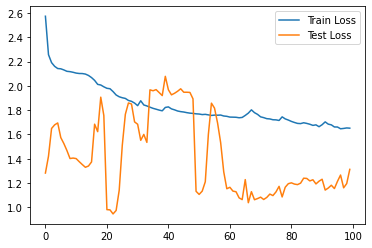

In [24]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = "Train Loss")
plt.plot(test_loss, label = "Test Loss")
plt.legend()
plt.show()

In [25]:
# output_user = sm_net.encoder_user(torch.Tensor(data_matrix).to(device)).cpu().detach().numpy()

In [26]:
# pd.DataFrame(output_user).to_csv("user.csv", index = False)

In [27]:
# sm_net.decoder_user(torch.Tensor(output_user).to(device)).cpu().detach().numpy()

In [28]:
# data_matrix

In [29]:
output_item = sm_net.encoder_item(torch.Tensor(embeddings_).to(device)).cpu().detach().numpy()

In [30]:
pd.DataFrame(output_item).to_csv("../Datasets/ml-100k/Compressed/video.csv", index = False)

In [31]:
sm_net.decoder_item(torch.Tensor(output_item).to(device)).cpu().detach().numpy()

array([[0.33217546, 0.33290118, 0.33056056, ..., 0.33211565, 0.33286873,
        0.3322616 ],
       [0.33217546, 0.33290118, 0.33056056, ..., 0.33211565, 0.33286873,
        0.3322616 ],
       [0.33217546, 0.33290118, 0.33056056, ..., 0.33211565, 0.33286873,
        0.3322616 ],
       ...,
       [0.33217546, 0.33290118, 0.33056056, ..., 0.33211565, 0.33286873,
        0.3322616 ],
       [0.33217546, 0.33290118, 0.33056056, ..., 0.33211565, 0.33286873,
        0.3322616 ],
       [0.33217546, 0.33290118, 0.33056056, ..., 0.33211565, 0.33286873,
        0.3322616 ]], dtype=float32)

In [32]:
embeddings_

array([[0.49816228, 0.64105329, 0.17910998, ..., 0.60482278, 0.86077272,
        0.27575648],
       [0.34419216, 0.21264084, 0.10639793, ..., 0.15066184, 0.22562452,
        0.38929238],
       [0.53532769, 0.4175338 , 0.06497518, ..., 0.1537495 , 0.38028206,
        0.22736926],
       ...,
       [0.27550164, 0.26147485, 0.04548932, ..., 0.48796912, 0.38855514,
        0.2447573 ],
       [0.18166006, 0.49854062, 0.17123461, ..., 0.4009553 , 0.26297376,
        0.311853  ],
       [0.32307922, 0.49533578, 0.10803397, ..., 0.19856427, 0.16038521,
        0.38617495]])

##### 